In [ ]:
#CRISP-DM Project Outline
#This notebook provides an outline for a data science project following the CRISP-DM methodology.
#State of art
#Aujourd’hui, les plateformes de mobilité comme Uber utilisent beaucoup les nouvelles technologies et l’analyse des informations pour mieux fonctionner et offrir une meilleure expérience aux utilisateurs. Elles arrivent ainsi à relever plusieurs défis, comme donner un prix plus juste en temps réel, prévoir plus précisément l’heure d’arrivée d’un véhicule, ou encore mieux connaître les habitudes des clients afin de leur proposer des offres adaptées. En s’appuyant sur l’étude de grandes quantités de données issues des trajets, du comportement des passagers et des conditions extérieures comme le trafic, la météo ou l’heure de la journée, ces entreprises réussissent à prendre de meilleures décisions. Cela leur permet d’être plus efficaces, de réduire les annulations de courses et de renforcer la fidélité des clients.#1. Business Understanding
#Define the Business Objectives (BOs)
#BO 1:Fournir une estimation fiable et rapide du coût d’un trajet Uber.
#BO 2:Réduire les temps d’attente des passagers d'un uberen prédisant leur ETA (Estimated Time of Arrival)
#BO 3:Identifier et anticiper les zones de forte demande (hotspots) afin de mieux répartir les chauffeurs et éviter les ruptures de disponibilité.
#Define the Data Science Objectives (DSOs)
#DSO 1:Construire un modèle de régression robuste qui prédit le fare_amount avec une erreur faible (MAE/RMSE bas).
#DSO 2:Développer un modèle prédictif capable d’estimer la durée du trajet afin de fournir au client un temps d’arrivée réaliste
#DSO 3:Appliquer des techniques de clustering non supervisé (ex. K-Means, DBSCAN) pour segmenter les trajets selon le lieu


Aperçu des données :
   Unnamed: 0                            key  fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count
0  24238194.0    2015-05-07 19:52:06.0000003          7.5  2015-05-07 19:52:06 UTC        -73.999817        40.738354         -73.999512         40.723217              1.0
1  27835199.0    2009-07-17 20:04:56.0000002          7.7  2009-07-17 20:04:56 UTC        -73.994355        40.728225         -73.994710         40.750325              1.0
2  44984355.0   2009-08-24 21:45:00.00000061         12.9                      NaN        -74.005043        40.740770                NaN         40.772647              1.0
3  25894730.0    2009-06-26 08:22:21.0000001          5.3  2009-06-26 08:22:21 UTC        -73.976124              NaN         -73.965316         40.803349              3.0
4  17610152.0  2014-08-28 17:47:00.000000188         16.0  2014-08-28 17:47:00 UTC               NaN        40.744085  

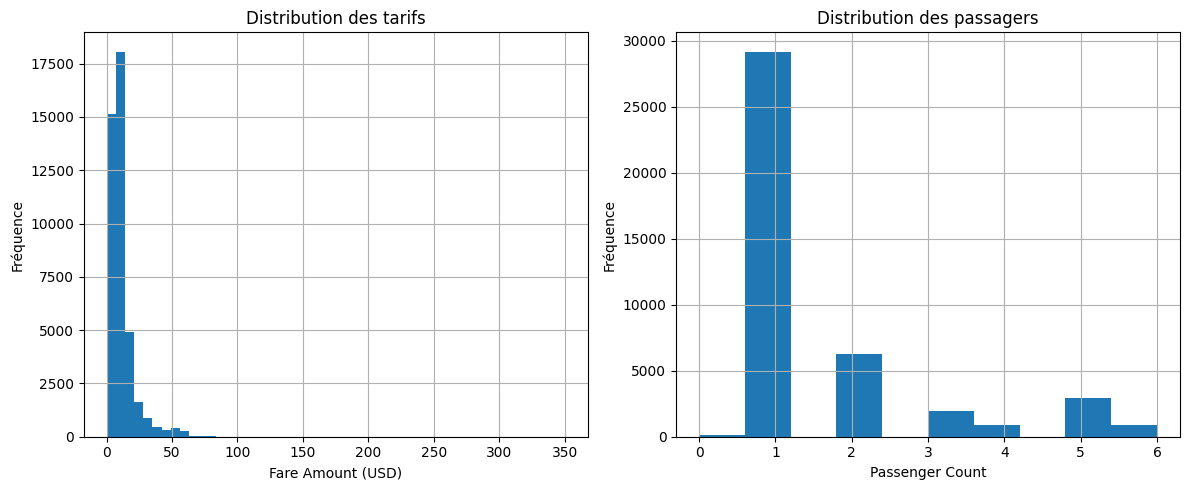


Nombre de trajets avec même départ et arrivée : 977
📌 Dimensions du dataset : (44377, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194.000000,2015-05-07 19:52:06.0000003,7.500000,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1.000000
1,27835199.000000,2009-07-17 20:04:56.0000002,7.700000,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1.000000
2,44984355.000000,2009-08-24 21:45:00.00000061,12.900000,nan,-74.005043,40.740770,nan,40.772647,1.000000
3,25894730.000000,2009-06-26 08:22:21.0000001,5.300000,2009-06-26 08:22:21 UTC,-73.976124,nan,-73.965316,40.803349,3.000000
4,17610152.000000,2014-08-28 17:47:00.000000188,16.000000,2014-08-28 17:47:00 UTC,nan,40.744085,-73.973082,nan,5.000000
5,44470845.000000,2011-02-12 02:27:09.0000006,4.900000,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,1.000000
6,48725865.000000,2014-10-12 07:04:00.0000002,24.500000,2014-10-12 07:04:00 UTC,nan,40.693965,-73.871195,40.774297,5.000000
7,44195482.000000,2012-12-11 13:52:00.00000029,2.500000,2012-12-11 13:52:00 UTC,0.000000,0.000000,0.000000,0.000000,1.000000
8,15822268.000000,2012-02-17 09:32:00.00000043,9.700000,2012-02-17 09:32:00 UTC,-73.975187,40.745767,-74.002720,40.743537,1.000000
9,50611056.000000,2012-03-29 19:06:00.000000273,12.500000,2012-03-29 19:06:00 UTC,-74.001065,40.741787,-73.963040,nan,1.000000



📈 Statistiques descriptives :


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,42243.000000,42217.000000,42183.000000,42130.000000,42183.000000,42119.000000,42159.000000
mean,27672899.814928,11.409233,-72.568666,39.948790,-72.588555,39.957229,1.677720
std,16026783.122156,10.091979,10.776933,6.006307,10.684628,5.962407,1.296484
min,48.000000,0.000000,-748.016667,-74.015515,-737.916665,-74.008745,0.000000
25%,13724835.500000,6.000000,-73.992075,40.734808,-73.991496,40.733766,1.000000
50%,27651919.000000,8.500000,-73.981857,40.752503,-73.980170,40.752910,1.000000
75%,41510200.500000,12.600000,-73.967187,40.767077,-73.963738,40.768162,2.000000
max,55421687.000000,350.000000,40.774042,45.031653,40.828377,45.031598,6.000000


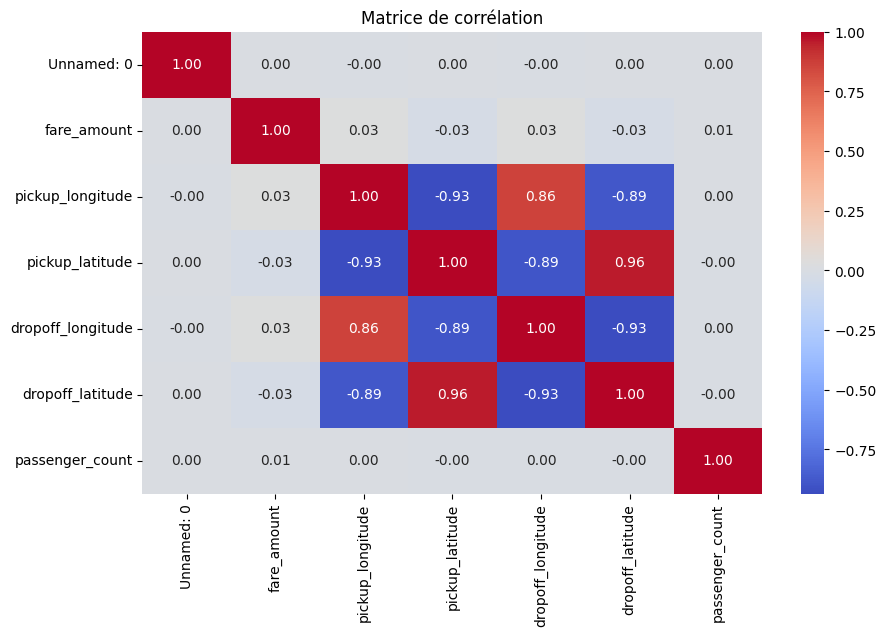

In [14]:
#2. Data Understanding
#Collect and get an initial understanding of the data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Charger le dataset Excel (adapter le chemin)
df = pd.read_excel("datauber.xlsx")   # Mets le vrai nom de ton fichier

# 2. Aperçu des données
print("Aperçu des données :")
print(df.head())
print(df.shape)

print("\nInfos générales :")
print(df.info())

# 3. Vérifier valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())

# 4. Statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe(include="all"))

# 5. Vérifier les valeurs uniques pour passenger_count
print("\nValeurs uniques passenger_count :")
print(df["passenger_count"].value_counts(dropna=False))

# 6. Visualisations simples
plt.figure(figsize=(12,5))

# Distribution des tarifs
plt.subplot(1,2,1)
df["fare_amount"].hist(bins=50)
plt.xlabel("Fare Amount (USD)")
plt.ylabel("Fréquence")
plt.title("Distribution des tarifs")

# Distribution du nombre de passagers
plt.subplot(1,2,2)
df["passenger_count"].hist(bins=10)
plt.xlabel("Passenger Count")
plt.ylabel("Fréquence")
plt.title("Distribution des passagers")

plt.tight_layout()
plt.show()

# 7. Vérifier cohérence pickup vs dropoff (distance = 0)
same_location = df[
    (df["pickup_longitude"] == df["dropoff_longitude"]) &
    (df["pickup_latitude"] == df["dropoff_latitude"])
]
print(f"\nNombre de trajets avec même départ et arrivée : {len(same_location)}")

# ========== Réglages d'affichage ==========
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 1000)
# ========== 1. Aperçu du dataset ==========
print("📌 Dimensions du dataset :", df.shape)
display(df.head(10).style.set_caption("Aperçu des 10 premières lignes")
        .background_gradient(cmap="Blues"))

# ========== 3. Statistiques descriptives ==========
print("\n📈 Statistiques descriptives :")
display(df.describe().style.background_gradient(cmap="Oranges"))

# 2.5 Matrice de corrélation
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()


In [15]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
from datetime import timedelta

# Charger le dataset
df = pd.read_excel("datauber.xlsx")

# Supprimer doublons
df = df.drop_duplicates()

# Imputer valeurs manquantes
df["passenger_count"] = df["passenger_count"].fillna(1)
df["fare_amount"] = df["fare_amount"].fillna(df["fare_amount"].median())
for col in ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]:
    df[col] = df[col].fillna(df[col].median())

df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
most_freq_date = df["pickup_datetime"].mode()[0]
df["pickup_datetime"] = df["pickup_datetime"].fillna(most_freq_date)

# Nettoyage valeurs aberrantes
df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 200)]
df = df[(df["passenger_count"] > 0) & (df["passenger_count"] <= 6)]

# Coordonnées réalistes NYC
df = df[(df["pickup_longitude"] > -80) & (df["pickup_longitude"] < -70)]
df = df[(df["pickup_latitude"] > 35) & (df["pickup_latitude"] < 45)]
df = df[(df["dropoff_longitude"] > -80) & (df["dropoff_longitude"] < -70)]
df = df[(df["dropoff_latitude"] > 35) & (df["dropoff_latitude"] < 45)]

# pickup != dropoff
df = df[~((df["pickup_longitude"] == df["dropoff_longitude"]) &
          (df["pickup_latitude"] == df["dropoff_latitude"]))]

# ==================================================
# Variables temporelles
# ==================================================
df["booking_time"] = df["pickup_datetime"]
df["hour"] = df["pickup_datetime"].dt.hour
df["day_of_week"] = df["pickup_datetime"].dt.dayofweek  # 0=lundi
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

# ==================================================
# Traffic_level basé sur l'heure de réservation
# ==================================================
def traffic_from_booking(hour, day_of_week):
    if 0 <= hour < 5:
        return 0  # très faible
    elif 5 <= hour < 7:
        return 1  # faible
    elif 7 <= hour < 9 or 17 <= hour < 19:
        return 4  # heures de pointe
    elif 9 <= hour < 10 or 16 <= hour < 17:
        return 3  # assez élevé
    elif 10 <= hour < 16:
        return 2  # modéré
    else:
        return 1 if day_of_week < 5 else 3  # soirées semaine = faible, week-end = plus élevé

df["traffic_level"] = df.apply(lambda row: traffic_from_booking(row["hour"], row["day_of_week"]), axis=1)

# ==================================================
# Distance Haversine
# ==================================================
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r

df["distance_km"] = df.apply(lambda row: haversine(
    row["pickup_longitude"], row["pickup_latitude"],
    row["dropoff_longitude"], row["dropoff_latitude"]), axis=1)

df = df[(df["distance_km"] > 0) & (df["distance_km"] < 100)]

# ==================================================
# ETA (arrival_time estimée)
# ==================================================
df["trip_duration_min"] = df["distance_km"] / 0.5  # vitesse moyenne 30 km/h
df["arrival_time"] = df["booking_time"] + df["trip_duration_min"].apply(lambda x: timedelta(minutes=x))

# ==================================================
# Aperçu final
# ==================================================
print(df[["fare_amount", "distance_km", "hour", "traffic_level", "booking_time", "arrival_time"]].head())




   fare_amount  distance_km  hour  traffic_level              booking_time                     arrival_time
0          7.5     1.683323    19              1 2015-05-07 19:52:06+00:00 2015-05-07 19:55:27.998730+00:00
1          7.7     2.457590    20              1 2009-07-17 20:04:56+00:00 2009-07-17 20:09:50.910786+00:00
2         12.9     4.117407    13              2 2009-01-11 13:07:00+00:00 2009-01-11 13:15:14.088832+00:00
3          5.3     5.726152     8              4 2009-06-26 08:22:21+00:00 2009-06-26 08:33:48.138278+00:00
4         16.0     1.227506    17              4 2014-08-28 17:47:00+00:00 2014-08-28 17:49:27.300724+00:00


In [ ]:
#4. MODELING
#Select and apply different modeling techniques to find patterns and insights.

In [ ]:
#5. EVALUATION & TEST
#Assess the performance of the models and determine if they meet the business objectives.

In [ ]:
#6. DEPLOYMENT
#Implement the chosen model into a real-world application or deliver the results to stakeholders.